In [1]:
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import sys

source_dir = os.path.realpath("../bpr")
sys.path.append(source_dir)

import matplotlib.pyplot as plt
import numpy as np


from scipy.special import softmax
from sklearn.manifold import TSNE
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from utils import load_ml100k, Dataset

In [3]:
dataset = load_ml100k(split_type='leave_one_out')

In [4]:
def kde_probs(
    dataset: Dataset,
    *,
    perplexity: int = 5,
    learning_rate: int = 150,
    n_jobs: int = -1,
    plot: bool = False,
    softmaxed: bool = False
):
    """
    Compute per-sample probabilities based on KDE of 2D embeddings
    
    Returns:
        np.ndarray: probabilities the same order as the rows in dataset.test_matrx
    """
    X_embedded = TSNE(
        perplexity=perplexity, learning_rate=learning_rate, n_jobs=n_jobs
    ).fit_transform(dataset.train_matrix)
    kde = KernelDensity().fit(X_embedded)
    scores = kde.score_samples(X_embedded)
    print(scores.shape)
    print(scores.min(), scores.max())
    scores_scaled = MinMaxScaler().fit_transform(scores.reshape(-1, 1))
    scores_scaled = np.squeeze(scores_scaled) + 1
    if plot:
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.3)
        plt.show()
        plt.hist(np.squeeze(scores))
        plt.show()
        plt.hist(scores_scaled)
        plt.show()
        
    if softmaxed:
        probs = np.squeeze(softmax(scores.reshape(-1, 1)))
    else:
        probs = scores_scaled/np.sum(scores_scaled)
    return scores, probs

(943,)
-8.686943349042803 -7.14133709135245


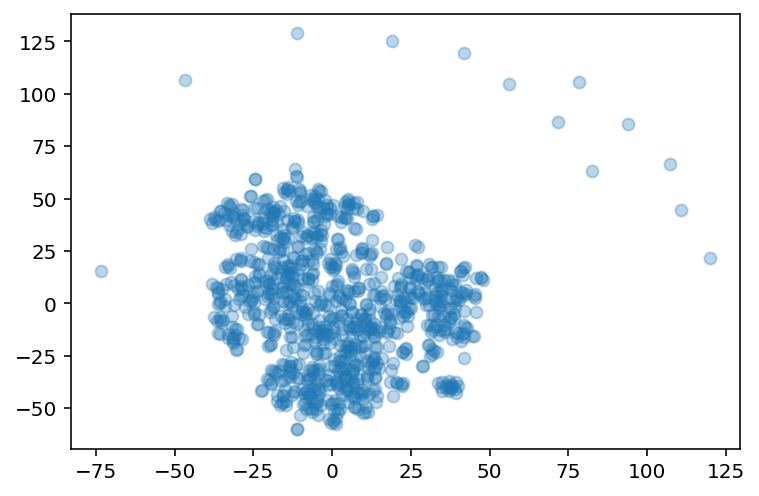

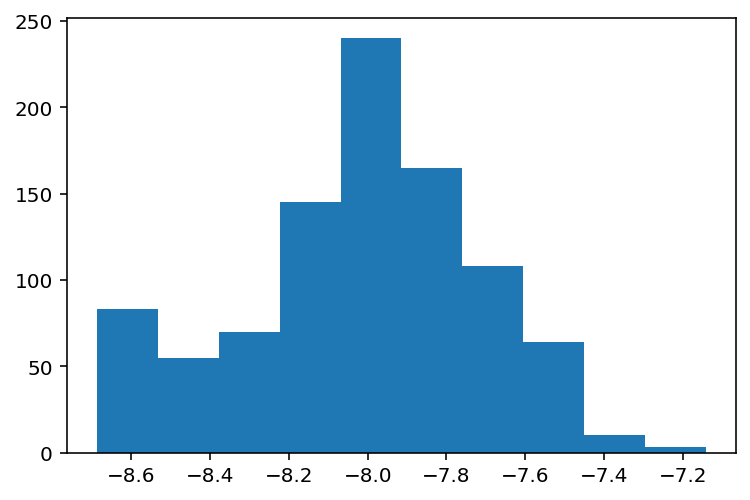

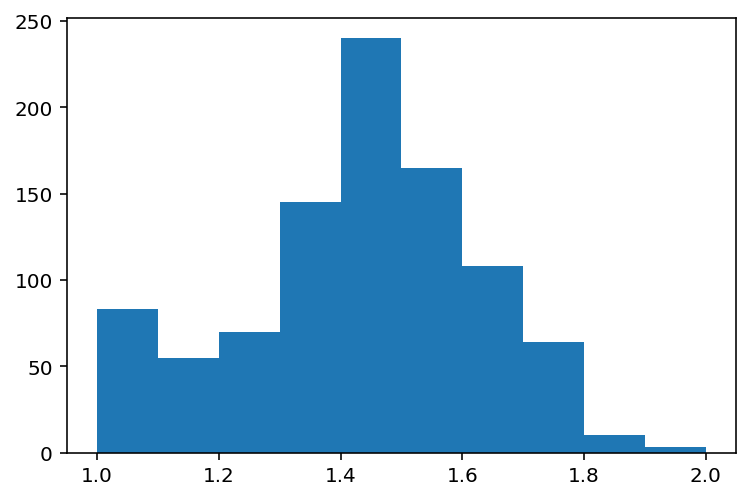

In [5]:
scores, probs = kde_probs(dataset, plot=True)

In [6]:
scores_adjusted = scores + np.max(np.abs(scores))
scores_adjusted_1 = scores + np.max(scores)

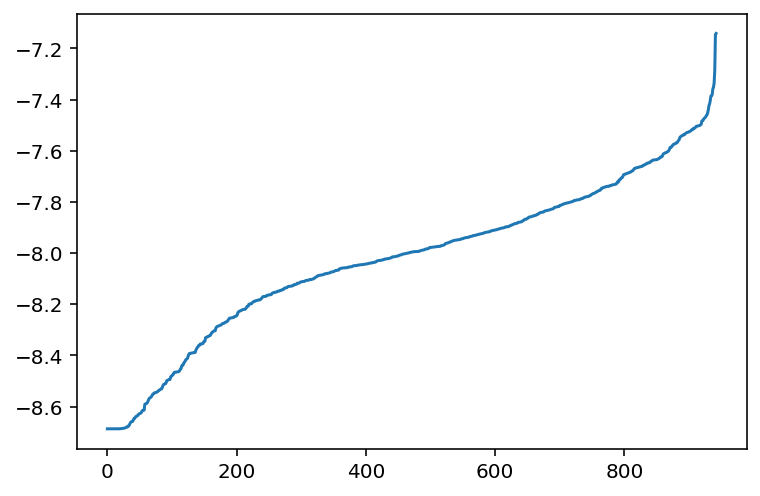

In [7]:
plt.plot(np.sort(scores))

In [8]:
from scipy.signal import argrelextrema
mi, ma = argrelextrema(np.sort(scores), np.less)[0], argrelextrema(np.sort(scores), np.greater)[0]

In [9]:
np.sort(scores)[ma]

array([], dtype=float64)

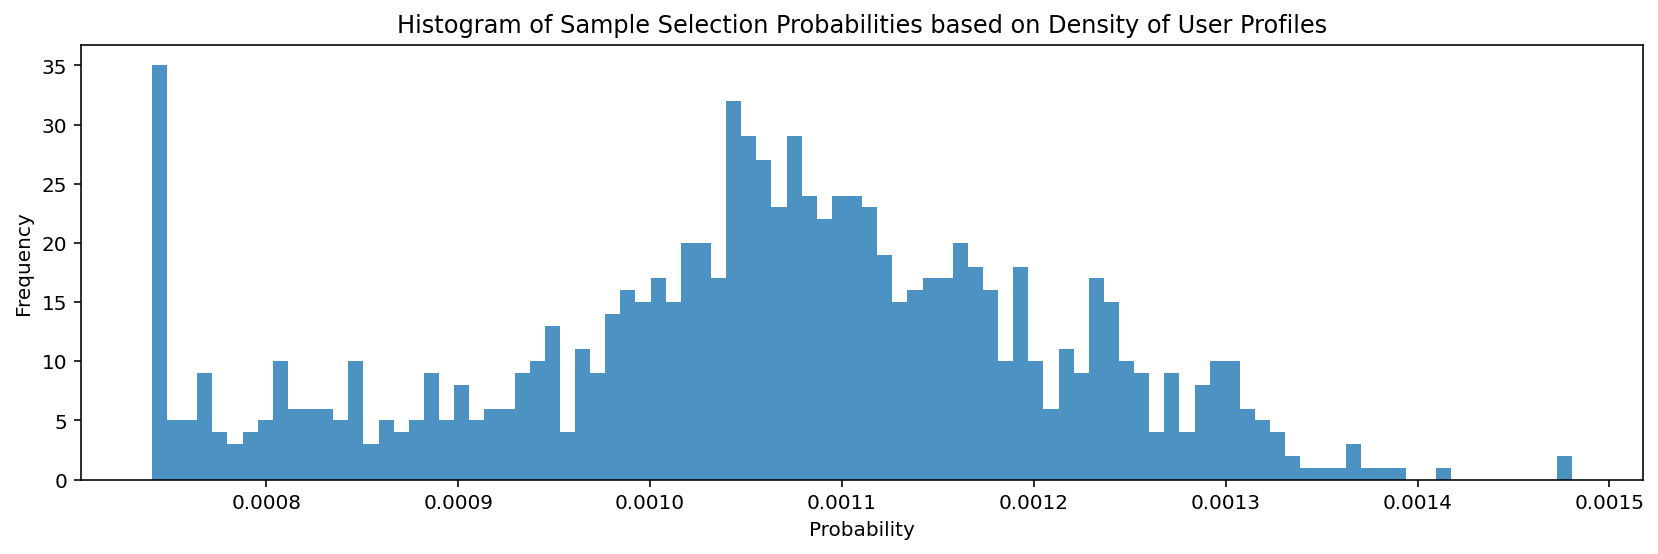

In [10]:
fig = plt.figure(figsize=(14, 4))
_ = plt.hist(probs, bins=probs.shape[0]//10, alpha=0.8)
plt.xlabel("Probability")
plt.ylabel("Frequency")
_ = plt.title("Histogram of Sample Selection Probabilities based on Density of User Profiles")

In [11]:
def srs_candidates(scores_kde: np.ndarray, epochs: int, bins=10) -> np.ndarray:
    """Get candidates for stratified random sampling

    Args:
        scores_kde: density estimates for user profiles
        bins: number of buckets to split density estimatess
        epochs: number of epochs

    Returns:
        np.ndarray: rows correspond to users, columns map to epochs
    """
    bin_indices = np.digitize(
        scores_kde, bins=np.linspace(scores_kde.min(), scores_kde.max(), bins)
    )
    users_per_epoch = 0.5 * bin_indices.shape[0]
    users_per_bin = int(users_per_epoch // bins)

    candidates = np.zeros(shape=(bin_indices.shape[0], epochs), dtype=np.int)

    for epoch in range(epochs):
        for i in range(bin_indices.min(), bin_indices.max() + 1):
            user_ids = np.argwhere(bin_indices == i).reshape(-1)
            sampled_ids = np.random.choice(
                user_ids, size=min(users_per_bin, user_ids.shape[0]), replace=False
            )
            candidates[sampled_ids, 1] = 1
    return candidates

In [12]:
A = srs_candidates(scores, 500)

In [13]:
sys.path.remove(source_dir)